In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import numpy as np
import linecache #fast access to a specific file line
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import torch.nn.functional as F
import time
import torchinfo
from pathlib import Path

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

1.11.0
11.1
True


In [4]:
torch.multiprocessing.set_sharing_strategy('file_system') #to avoid issues in the dataloading
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
CONT_SIZE = 12

In [6]:
ALPHABET = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I",
            "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

ALPHABET = {ALPHABET[i]:i for i in range(len(ALPHABET))}

ALPHABET['-']= 20
ALPHABET['Z']= 21

print(ALPHABET)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, '-': 20, 'Z': 21}


In [7]:
#max 4
rep = torch.tensor([4, 4, 2, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4])
rand = torch.tensor([0, 0, 0.2, 0, 0, 0, 0, 0, 0, 0.5, 0.7, 0, 0, 0, 0, 0, 0, 0,0, 0])
#max 8 
rep = torch.tensor([8, 8, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 5, 7, 8, 8, 8, 8, 8])
rand = torch.tensor([0, 0, 0.2, 0, 0, 0, 0, 0, 0.2, 0.5, 0.3, 0.9, 0.8, 0.5, 0.9, 0, 0, 0, 0, 0])

In [8]:
class MyDataset(Dataset):
    def __init__(self, data_dir, cont_size=6,div=1400000,verbose=False):
        """
        Initialize the dataset by precomputing a bunch of data on the sequence families
        """
        self.col_size = 60 #number of column per file (Fasta standard)
        self.data_dir = data_dir #directory of the dataset
        self.cont_size = cont_size
        self.div = div
        self.len = 0  #number of families of sequences (1 per file)
        self.paths = {} #path of each families in the folder
        self.seq_lens = {} #length of each member of the family
        self.seq_nums = {} #number of member of the family
        self.aa_freqs = {} #frequencies of each symbol in the sequence family
        self.p_aa_freqs = {} #frequencies of each symbol in each sequence of a family
        
        
        dir_path = data_dir
        count = 0
        
        # Iterate directory
        for path in os.listdir(dir_path):
            # check if current path is a file
            temp_path = os.path.join(dir_path, path)
            if os.path.isfile(temp_path):
                n = 0 #number of sequences
                p = 0 # used to calculate the length of the sequences
                r = 0 # also used this way

                l = 0 # length of the seq l = p * self.col_size + r 

                cpt = 0 # to detect inconsistencies
                
                with open(temp_path, newline='') as f:
                    first_prot = True
                    newf = True
                    
                    aa_freq = torch.zeros(20)
                    p_aa_freq = torch.zeros(0)
                    
                    #parsing the file
                    line = f.readline()[:-1]
                    while line:
                        cpt += 1
                        if line[0] == '>': #header line
                            if not first_prot:
                                p_aa_freq = torch.cat([p_aa_freq,prot_aa_freq])
                            prot_aa_freq = torch.zeros(1,20)
                            n += 1
                            if newf and not first_prot:
                                newf = False
                            first_prot = False
                                
                        else:# sequence line
                            if newf and len(line) == self.col_size:
                                p += 1

                            if newf and len(line) != self.col_size:
                                r = len(line)
                            for aa in line:
                                aa_id = ALPHABET.get(aa,21)
                                if aa_id < 20:
                                    aa_freq[aa_id] += 1
                                    prot_aa_freq[0][aa_id] += 1

                            assert len(line) == self.col_size or len(line) == r
                        line = f.readline()[:-1]
                    
                    p_aa_freq = torch.cat([p_aa_freq,prot_aa_freq])
                    aa_freq = F.normalize(aa_freq,dim=0,p=1)
                    p_aa_freq = F.normalize(p_aa_freq,dim=1,p=1)

                l = p*self.col_size + r
                
                #sanity check
                #if the file line count is coherent with the number of sequences and their line count
                try: #if r != 0
                    assert (p+2) * n == cpt
                except: #if r == 0
                    assert (p+1) * n == cpt
                    assert r == 0
                    
                
                if n>1: #if this is false, we can't find pairs
                    self.paths[count] = path
                    self.seq_lens[count] = l
                    self.seq_nums[count] = n
                    self.aa_freqs[count] = aa_freq
                    self.p_aa_freqs[count] = p_aa_freq
                    count += 1
                    
                    if verbose and (count % 100 ==0) : print(f"seen = {count}")
            
        self.len = count
    
    def __len__(self):
        return self.len
     
    def sample(self, high, low=0, s=1):
        sample = np.random.choice(high-low, s, replace=False)
        return sample + low
    
    def __getitem__(self, idx, sample_size='auto',rep=rep,rand=rand): 
        """
        input idx of the family of the sample
        return a Tensor containing several samples from the family corresponding to the index
        """
        
        X = []
        y = []
        
        PIDs = []
        local_PIDs = []
        
        pfreqs = []
        local_pfreqs = []
        
        lengths = []
        
        pos = []
        
        bin_n = len(rep) #for biasing the sampling
        
        precomputed_pos = [] #positions of the amino-acids
        for i in range(-self.cont_size,self.cont_size+1):
            precomputed_pos.append(i)
        for i in range(-self.cont_size,0):
            precomputed_pos.append(i)
        for i in range(1,self.cont_size+1):
            precomputed_pos.append(i)
        
        precomputed_pos = torch.tensor(precomputed_pos).float()
        
        data_path = os.path.join(self.data_dir, self.paths[idx])
        try:
            n = self.seq_nums[idx]
            l = self.seq_lens[idx]
        except:
            print(idx)
            pass
        
        #sampling more for big families and long sequences
        if type(sample_size) != int:
            sample_s = min(n * l,25_000)
            coef = round((sample_s)/self.div) 
            sample_size = max(1,coef)
        
        p = l // self.col_size
        r = l % self.col_size # l = p * q + r
        sequence_line_count = p+2 if r else p+1

        for _ in range(sample_size):
            i,j = self.sample(n,s=2)

            start_i = 2 + (sequence_line_count)*i #start line of protein i
            start_j = 2 + (sequence_line_count)*j #start line of protein j
            
            seq_i = ''
            seq_j = ''
            
            PID_ij = 0
            
            l_ij = 0
            for offset in range(sequence_line_count-1): #computing PID and removing aligned '-' ##might need to compute the actual column num
                line_i = linecache.getline(data_path, (start_i + offset))[:-1]
                line_j = linecache.getline(data_path, (start_j + offset))[:-1]
                for aa_i, aa_j in zip(line_i,line_j):
                    if aa_i == aa_j:
                        if aa_i != '-':
                            PID_ij += 1
                            seq_i += aa_i
                            seq_j += aa_j        
                    else:
                        seq_i += aa_i
                        seq_j += aa_j
                    
                    if aa_i != '-' and aa_j != '-':
                        l_ij += 1
            
            try:
                PID_ij = PID_ij/l_ij
            except:
                PID_ij = 0 #case 0/0
            
            align_l = len(seq_i)
            possible_k = [] #possible position to take
            for k,(a_i,a_j) in enumerate(zip(seq_i,seq_j)):   
                if ALPHABET.get(a_i,21) < 20 and ALPHABET.get(a_j,21) < 20:
                    possible_k.append(k)
            
            # biasing for more diverse PID  
            bin_idx = int(PID_ij//(1/bin_n))
            rep_number = rep[bin_idx].clone()
            if torch.rand(1) < rand[bin_idx]:
                rep_number+=1
            
            for _ in range(rep_number):
                try:   
                    k = np.random.choice(possible_k)
                except:
                    continue
                
                #adding to the output
                lengths.append(align_l)
                pos_ij = (k + precomputed_pos)
                pos.append(pos_ij)
                
                #computing the windows
                window_i = ''
                window_j = ''
                for w in range(k-self.cont_size,k+self.cont_size+1):
                    if w < 0 or w >= align_l: #case of the edges
                        window_i += 'Z'
                        window_j += 'Z'
                    else:
                        window_i += seq_i[w]
                        window_j += seq_j[w]

                y_j = ALPHABET.get(window_j[self.cont_size], 21) # 'Z' is the default value for rare AA
                X_i = [ALPHABET.get(i, 21) for i in (window_i+window_j[:self.cont_size]+window_j[self.cont_size+1:])]       

                X.append(X_i)
                y.append(y_j)
                PIDs.append(PID_ij)
                #computing the local PID
                local_PID_ij = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if AA1 == AA2 and ALPHABET.get(AA1,21) < 20) \
                             + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if AA1 == AA2 and ALPHABET.get(AA1,21) < 20)

                loc_comp = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if ALPHABET.get(AA1,21) < 20 and ALPHABET.get(AA2,21) < 20) \
                             + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if ALPHABET.get(AA1,21) < 20 and ALPHABET.get(AA2,21) < 20)
                try:
                    tmp = local_PID_ij/loc_comp  
                except:
                    tmp = 0 #case 0/0

                local_PIDs.append(tmp)
                pfreqs.append(self.aa_freqs[idx])
                p_i_freqs = self.p_aa_freqs[idx][i]
                p_j_freqs = self.p_aa_freqs[idx][j]

                local_pfreqs.append(torch.stack((p_i_freqs,p_j_freqs)))

                assert y_j < 20
                assert X_i[self.cont_size] < 20
            
        linecache.clearcache() #clearing the cache
        X = torch.tensor(X)
        try:
            X = F.one_hot(X,22)[:,:,0:-1]
        except RuntimeError:
            pass
        if len(pos) == 0:
            pos = torch.tensor(pos)
        else:
            pos = torch.stack(pos)
        pfreqs = torch.stack(pfreqs)
        local_pfreqs = torch.stack(local_pfreqs)
        X = X.float()
        y = torch.tensor(y)
        PIDs = torch.tensor(PIDs)
        local_PIDs = torch.tensor(local_PIDs)
        lengths = torch.tensor(lengths)
        out = X,y.long(),PIDs,local_PIDs,pfreqs,local_pfreqs,pos,lengths
        return out


In [9]:
#Run This for new data
"""
train_dataset = MyDataset(r"data/train_data",cont_size = 6,4000)
test_dataset = MyDataset(r"data/test_data",cont_size = 6,div=2000)
val_dataset = MyDataset(r"data/val_data",cont_size = 6,div=2000)

fname = 'data/train_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(train_dataset,fp)
    
fname = 'data/test_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(test_dataset,fp)
    
fname = 'data/val_dataset1.pth'
savepath = Path(fname)
with savepath.open("wb") as fp:
    torch.save(val_dataset,fp)
"""

'\ntrain_dataset = MyDataset(r"data/train_data",cont_size = 6,4000)\ntest_dataset = MyDataset(r"data/test_data",cont_size = 6,div=2000)\nval_dataset = MyDataset(r"data/val_data",cont_size = 6,div=2000)\n\nfname = \'data/train_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(train_dataset,fp)\n    \nfname = \'data/test_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(test_dataset,fp)\n    \nfname = \'data/val_dataset1.pth\'\nsavepath = Path(fname)\nwith savepath.open("wb") as fp:\n    torch.save(val_dataset,fp)\n'

In [10]:
#To load datasets with all features computed
fname = 'data/train_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    train_dataset = torch.load(fp)
    
fname = 'data/test_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    test_dataset = torch.load(fp)
    
fname = 'data/val_dataset1.pth'
savepath = Path(fname)
with savepath.open("rb") as fp:
    val_dataset = torch.load(fp)
    
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

train_dataset.cont_size = CONT_SIZE
test_dataset.cont_size = CONT_SIZE
val_dataset.cont_size = CONT_SIZE

train_dataset.div = 2000
test_dataset.div = 2000
val_dataset.div = 2000

13219
2838
2826


In [11]:
def my_collate(batch):
    """
    Transforms a list of tensors to a batch tensor
    """
    data = torch.cat([item[0] for item in batch],dim=0)
    target = torch.cat([item[1] for item in batch],dim=0)
    PID = torch.cat([item[2] for item in batch],dim=0)
    lPID = torch.cat([item[3] for item in batch],dim=0)
    pfreqs = torch.cat([item[4] for item in batch],dim=0)
    lpfreqs = torch.cat([item[5] for item in batch],dim=0)
    pos = torch.cat([item[6] for item in batch],dim=0)
    length = torch.cat([item[7] for item in batch],dim=0)
    return data, target, PID, lPID,pfreqs,lpfreqs, pos, length

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True,collate_fn=my_collate,num_workers=4)

In [13]:
class AttBlock(nn.Module):
    """
    Attention Block of the Transformer
    """
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        self.lin = nn.Linear(num_heads*head_dims,out_features)
        
    def forward(self,x):
        Q = self.Q_w(x)
        K = self.K_w(x)
        V = self.V_w(x)
        out,_ = self.att(Q,K,V,need_weights=False)
        out = self.lin(out)
        
        return out

In [14]:
class FeedFoward(nn.Module):
    """
    MLP Block of the Transformer
    """    
    def __init__(self,in_features,out_features=None,wide_factor=4):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = wide_factor * in_features
        
        self.lin1 = nn.Linear(in_features,hidden_dim)
        self.act1 = nn.GELU()
        self.lin2 = nn.Linear(hidden_dim,out_features)
        self.act2 = nn.GELU()
        
    def forward(self,x):
        out = self.lin1(x)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        
        return out

In [15]:
#(from the timm library)
def drop_path(x, drop_prob: float = 0.1, training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None, scale_by_keep=True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)


In [16]:
class Block(nn.Module):
    """
    Basic Block of the Transformer
    """
    def __init__(self,in_features,num_heads=8,head_dims=24,wide_factor=4,drop=0.1):
        super().__init__()
        
        self.att_block = AttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.ff = FeedFoward(in_features,wide_factor=wide_factor)
        self.drop_path = DropPath(drop)
        
        self.norm1 = nn.LayerNorm(in_features)
        self.norm2 = nn.LayerNorm(in_features)
    def forward(self,x):
        out = x + self.drop_path(self.att_block(x))
        out = self.norm1(out)
        out = out + self.drop_path(self.ff(out))
        out = self.norm2(out)
        return out

In [17]:
class Classifier_Head(nn.Module):
    """
    Classifier Head of the Transformer
    """
    def __init__(self,in_features,clf_dims,out_size,seq_len):
        super().__init__()
        in_dim = seq_len*in_features
        self.in_dim = in_dim
        
        layers = []
        for out_dim in clf_dims:
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(p=0.2))
            in_dim = out_dim

        layers.append(nn.Linear(in_dim,out_size))
        
        self.clf = nn.Sequential(*layers)
        
    def forward(self,x):
        out = x.reshape((-1,self.in_dim))
        
        out = self.clf(out)
        
        return out

In [18]:
class AttNet(nn.Module):
    """
    Transformer-like neural net
    """
    def __init__(self,in_features,num_heads,head_dims,wide_factors,drops,input_dim=21,out_size=20,seq_len=4*CONT_SIZE+6,clf_dims=[256,64],cont_size=CONT_SIZE):
        super().__init__()
        
        blocks = []
        for n_h, h_d,w,d in zip(num_heads,head_dims,wide_factors,drops):
            blocks.append(Block(in_features,num_heads=n_h,head_dims=h_d,wide_factor=w,drop=d))
        self.feature_extractor = nn.Sequential(*blocks)
        self.in_features = in_features
        self.input_dim = input_dim
        self.clf = Classifier_Head(in_features,clf_dims,out_size=out_size,seq_len=seq_len)
        
        self.cont_size=cont_size
        
        sp = Path("data/freq.pth")
        with sp.open("rb") as fp:
            self.F = nn.Parameter(torch.log(torch.load(fp)))
            
        pid_layers = [nn.Linear(1,in_features),nn.Sigmoid()]
        self.pid_l = nn.Sequential(*pid_layers)
    
    def to_input(self,x,PID,pfreqs,lpfreqs,pos,length):
        X_idx = torch.argmax(x[:,self.cont_size],dim=1)
        seq1 = x[:,:2*self.cont_size+1]
        y_freq = F.pad(F.softmax(self.F[X_idx],dim=1).unsqueeze(1), pad=(0, 1), mode='constant', value=0) 
        seq2 = torch.cat((x[:,2*self.cont_size+1:3*self.cont_size+1],y_freq,x[:,3*self.cont_size+1:]),dim=1)
        aa_pos = pos[:,:2*self.cont_size+1]/length.unsqueeze(1)
        aa_pos = aa_pos.unsqueeze(2)
        pos_dim = (self.in_features-self.input_dim-1)//2
        
        for i in range(pos_dim): #positionnal_encoding
            p = torch.cos(pos[:,:2*self.cont_size+1]/(4**(2*i/pos_dim))).unsqueeze(2)
            ip = torch.sin(pos[:,:2*self.cont_size+1]/(4**(2*i/pos_dim))).unsqueeze(2)
            aa_pos = torch.cat([aa_pos,p,ip],dim=2)
        
        seq1 = torch.cat([seq1,aa_pos],dim=2)
        seq2 = torch.cat([seq2,aa_pos],dim=2)
        X = torch.cat([seq1,seq2],dim=1)
        
        pad = (0,self.in_features-self.input_dim+1)
        pf = F.pad(pfreqs.unsqueeze(1),pad =pad, mode='constant', value=0)
        pid = self.pid_l(PID.unsqueeze(1)).unsqueeze(1)
        lpf = F.pad(lpfreqs,pad=pad, mode='constant', value=0)

        X_input = torch.cat([X,pf,lpf,pid],dim=1)
        
        return X_input
    
    def forward(self,x,PID,pfreqs,lpfreqs,pos,length):
        X_input = self.to_input(x,PID,pfreqs,lpfreqs,pos,length)
        features = self.feature_extractor(X_input)
        out = self.clf(features)
        return out

In [19]:
def get_params(input_size,N,head,head_dim,wide_factor,drop_prob):
    """
    Returns the initialization parameters of the Transformer
    """
    return input_size, [head for _ in range(N)], [head_dim for _ in range(N)], [wide_factor for _ in range(N)], [drop_prob for _ in range(N)], 

In [22]:
params = get_params(32,6,8,32,4,0.1)
model = AttNet(*params,clf_dims=[1024,256,64])
model = model.to(device)
torchinfo.summary(model,[(1,49,21),(1,),(1,20),(1,2,20),(1,49),(1,)])

Layer (type:depth-idx)                        Output Shape              Param #
AttNet                                        [1, 20]                   400
├─Sequential: 1-1                             [1, 32]                   --
│    └─Linear: 2-1                            [1, 32]                   64
│    └─Sigmoid: 2-2                           [1, 32]                   --
├─Sequential: 1-2                             [1, 54, 32]               --
│    └─Block: 2-3                             [1, 54, 32]               --
│    │    └─AttBlock: 3-1                     [1, 54, 32]               295,968
│    │    └─DropPath: 3-2                     [1, 54, 32]               --
│    │    └─LayerNorm: 3-3                    [1, 54, 32]               64
│    │    └─FeedFoward: 3-4                   [1, 54, 32]               8,352
│    │    └─DropPath: 3-5                     [1, 54, 32]               --
│    │    └─LayerNorm: 3-6                    [1, 54, 32]               64
│    └─Bloc

In [23]:
class State:
    """
    Used for checkpointing
    """
    def __init__(self,model,optim,scheduler):
        self.model = model
        self.optim = optim
        self.scheduler = scheduler
        self.epoch = 0

In [24]:
def eval_model(fname,train,test,val,N=10):
    """
    Evaluate the MSE (Brier Score) of the model
    """
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
        
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())

        score_train = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_train = }\n")

        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs, pos,length in test:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
        score_test = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_test = }\n")

        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs, pos, length in val:
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                lPID = lPID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
        score_val = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
        print(f"{score_val = }\n")
    
    return score_train, score_test, score_val

In [25]:
def eval_model_PID(fname,train,test,val,N=10):
    """
    Evaluate the MSE (Brier Score) of the model for different slices of PID in the data
    """
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
    bin_n = 20
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_train = torch.zeros(bin_n)
        bar_train = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_train[i] += 1
            Losses_train[i] += n
        Losses_train = Losses_train/bar_train
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_train,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Train dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_train,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Train dataset")
        plt.show()
        
        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in test:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_test = torch.zeros(bin_n)
        bar_test = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_test[i] += 1
            Losses_test[i] += n
        Losses_test = Losses_test/bar_test
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_test,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Test dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_test,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Test dataset")
        plt.show()
        
        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in val:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_val = torch.zeros(bin_n)
        bar_val = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_val[i] += 1
            Losses_val[i] += n
        Losses_val = Losses_val/bar_val
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_val,width=1/(bin_n+1))
        plt.title("Brier Score wrt PID on Val dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_val,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Val dataset")
        plt.show()
        
    return Losses_train, bar_train, Losses_test, bar_test, Losses_val,bar_val

In [26]:
def eval_model_acc_PID(fname,train,test,val,N=10):
    """
    Evaluate the accuracy of the model for different slices of PID in the data
    """
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
    bin_n = 20
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
                
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_train = torch.zeros(bin_n)
        bar_train = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_train[i] += 1
            Losses_train[i] += n
        Losses_train = Losses_train/bar_train
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_train,width=1/(bin_n+1))
        plt.title("Accuracy wrt PID on Train dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_train,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Train dataset")
        plt.show()
        
        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in test:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_test = torch.zeros(bin_n)
        bar_test = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_test[i] += 1
            Losses_test[i] += n
        Losses_test = Losses_test/bar_test
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_test,width=1/(bin_n+1))
        plt.title("Accuracy wrt PID on Test dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_test,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Test dataset")
        plt.show()
        
        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        PIDS = []
        for _ in range(N):
            for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in val:
                PIDS.append(PID)
  
                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = torch.argmax(y_hat,dim=1)

                eval_l = (y == y_hat).long()
                eval_losses.append(eval_l.detach().cpu())
        PIDS = torch.cat(PIDS)
        BINS = (PIDS/(1/bin_n)).long()
        scores = torch.cat(eval_losses).detach().cpu()
        
        Losses_val = torch.zeros(bin_n)
        bar_val = torch.zeros(bin_n)
        for i,n in zip(BINS,scores):
            bar_val[i] += 1
            Losses_val[i] += n
        Losses_val = Losses_val/bar_val
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),Losses_val,width=1/(bin_n+1))
        plt.title("Accuracy wrt PID on Val dataset")
        plt.show()
        plt.bar(np.arange(bin_n)/bin_n+(1/(2*bin_n)),bar_val,width=1/(bin_n+1))
        plt.title("Example count wrt PID on Val dataset")
        plt.show()
        
    return Losses_train, bar_train, Losses_test, bar_test, Losses_val,bar_val

In [28]:
def main(train_loader,val_loader,epochs=101,fname="models/state.pth",fnameb=None,state=None,last_epoch_sched=float('inf'),use_mut=True,cont_size=CONT_SIZE):
    """
    Trains a model
    """
    #to get the best model
    best = float('inf')
    
    #getting the acceleration device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    #loading from previous checkpoint
    if fnameb is None:
        fnameb = fname[:-4] + '_best' +fname[-4:]
        
    savepath = Path(fname)
    if savepath.is_file():
        with savepath.open("rb") as fp:
            state = torch.load(fp)
    else:
        if state is None:
            model = AttNet(22,[8,8,8],[24,24,24],[4,4,4],[0.1,0.1,0.1])
            model = model.to(device)
            optim = torch.optim.AdamW(model.parameters(),lr = 0.0001)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
            state = State(model,optim,scheduler)
    
    
    Loss = nn.CrossEntropyLoss(reduction='sum')
    LossMut = nn.BCELoss(reduction='sum')
    EvalLoss = nn.MSELoss(reduction='mean')
    
    #for logs
    List_Loss = []
    Eval_Loss = []
    for epoch in range(state.epoch, epochs):
        batch_losses = []
        state.model.train()
        for X,y, PID, lPID,pfreqs,lpfreqs,pos,length in train_loader:
            X = X.to(device)
            y = y.to(device)
            PID = PID.to(device)
            pos = pos.to(device)
            pfreqs = pfreqs.to(device)
            lpfreqs = lpfreqs.to(device)
            length = length.to(device)
            
            state.optim.zero_grad()
            y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
            

            if use_mut:
                X_idx = torch.argmax(X[:,cont_size],dim=1)
                y_true = (X_idx == y).float().unsqueeze(1)  #0 if a mutation happens else 1 
                y_pred = F.softmax(y_hat,dim=1)
                y_pred = y_pred.gather(1,X_idx.view(-1,1)) #the Xth component of y_hat should be predicting ^
                l = (Loss(y_hat,y) + LossMut(y_pred,y_true))/440 
            else:
                l = Loss(y_hat,y)/440 
            l.backward()
            state.optim.step()
            
            
            
            batch_losses.append(l.detach().cpu())
        List_Loss.append(torch.mean(torch.stack(batch_losses)).detach().cpu())
        state.epoch = epoch + 1
        if epoch < last_epoch_sched:
            state.scheduler.step()
        
        savepath = Path(fname)
        with savepath.open("wb") as fp:
            torch.save(state,fp)
        
        with torch.no_grad():
            eval_losses = [] 
            state.model.eval()
            for X,y, PID, lPID,pfreqs,lpfreqs, pos,length in val_loader:

                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                pos = pos.to(device)
                pfreqs = pfreqs.to(device)
                lpfreqs = lpfreqs.to(device)
                length = length.to(device)

                y_hat = state.model(X,PID,pfreqs,lpfreqs,pos,length)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).detach().cpu())
    
            score = torch.mean(torch.cat(eval_losses)).detach().cpu().item()
            Eval_Loss.append(score)
        
        if score < best :
            best = score
            savepath = Path(fnameb)
            with savepath.open("wb") as fp:
                torch.save(state,fp)
        
        print(f"epoch n°{epoch} : train_loss = {List_Loss[-1]}, val_loss = {Eval_Loss[-1]}") 


        
    return List_Loss,Eval_Loss,state

In [70]:
params = get_params(32,6,8,32,4,0.1)
model = AttNet(*params,clf_dims=[1024,256,64])
model = model.to(device)
optim = torch.optim.AdamW(model.parameters(),lr = 0.0003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optim,16,2)
state = State(model,optim,scheduler)

fname = "models/stateATT_6L_12cont_biased sampling.pth" 
start = time.time()
Train,Eval,_ = main(train_dataloader, val_dataloader,fname=fname,epochs=4080,state=state,use_mut=False)
stop = time.time()
print(stop-start)

epoch n°0 : train_loss = 2.7078588008880615, val_loss = 0.8323175311088562
epoch n°1 : train_loss = 2.255880117416382, val_loss = 0.7608538866043091
epoch n°2 : train_loss = 2.1833884716033936, val_loss = 0.7476219534873962
epoch n°3 : train_loss = 2.145447254180908, val_loss = 0.7499938011169434
epoch n°4 : train_loss = 2.1305720806121826, val_loss = 0.7456762194633484
epoch n°5 : train_loss = 2.1098127365112305, val_loss = 0.7507891654968262
epoch n°6 : train_loss = 2.118419885635376, val_loss = 0.7451786398887634
epoch n°7 : train_loss = 2.0947751998901367, val_loss = 0.7464073300361633
epoch n°8 : train_loss = 2.087336540222168, val_loss = 0.7500407099723816
epoch n°9 : train_loss = 2.090449094772339, val_loss = 0.7475588917732239
epoch n°10 : train_loss = 2.0792298316955566, val_loss = 0.7383466958999634
epoch n°11 : train_loss = 2.0862302780151367, val_loss = 0.740938663482666
epoch n°12 : train_loss = 2.084897994995117, val_loss = 0.7436497807502747
epoch n°13 : train_loss = 2.0

epoch n°109 : train_loss = 1.9840521812438965, val_loss = 0.7279499769210815
epoch n°110 : train_loss = 1.9725931882858276, val_loss = 0.7236574292182922
epoch n°111 : train_loss = 1.9734901189804077, val_loss = 0.726706326007843
epoch n°112 : train_loss = 2.007477045059204, val_loss = 0.7333267331123352
epoch n°113 : train_loss = 2.001431465148926, val_loss = 0.7292020320892334
epoch n°114 : train_loss = 2.001767158508301, val_loss = 0.729005753993988
epoch n°115 : train_loss = 1.9929035902023315, val_loss = 0.7324731349945068
epoch n°116 : train_loss = 2.0025761127471924, val_loss = 0.7357401847839355
epoch n°117 : train_loss = 2.000272035598755, val_loss = 0.7363021969795227
epoch n°118 : train_loss = 2.0034749507904053, val_loss = 0.7313282489776611
epoch n°119 : train_loss = 2.003446102142334, val_loss = 0.7346231937408447
epoch n°120 : train_loss = 1.9984562397003174, val_loss = 0.7332544922828674
epoch n°121 : train_loss = 1.9982668161392212, val_loss = 0.7358217835426331
epoch 

epoch n°217 : train_loss = 1.9441889524459839, val_loss = 0.7248989343643188
epoch n°218 : train_loss = 1.95054292678833, val_loss = 0.7246847152709961
epoch n°219 : train_loss = 1.9434691667556763, val_loss = 0.7268033027648926
epoch n°220 : train_loss = 1.9372066259384155, val_loss = 0.729185163974762
epoch n°221 : train_loss = 1.938293218612671, val_loss = 0.7301806807518005
epoch n°222 : train_loss = 1.9396922588348389, val_loss = 0.7287731766700745
epoch n°223 : train_loss = 1.9374659061431885, val_loss = 0.7261753678321838
epoch n°224 : train_loss = 1.9425712823867798, val_loss = 0.7231400012969971
epoch n°225 : train_loss = 1.9292234182357788, val_loss = 0.7240047454833984
epoch n°226 : train_loss = 1.9448230266571045, val_loss = 0.7239157557487488
epoch n°227 : train_loss = 1.931715488433838, val_loss = 0.7260242104530334
epoch n°228 : train_loss = 1.939355731010437, val_loss = 0.7244805693626404
epoch n°229 : train_loss = 1.9430782794952393, val_loss = 0.7276484966278076
epoch

epoch n°324 : train_loss = 1.9371881484985352, val_loss = 0.7279180288314819
epoch n°325 : train_loss = 1.9293138980865479, val_loss = 0.7245843410491943
epoch n°326 : train_loss = 1.9295066595077515, val_loss = 0.7291541695594788
epoch n°327 : train_loss = 1.9269031286239624, val_loss = 0.7290233969688416
epoch n°328 : train_loss = 1.9316941499710083, val_loss = 0.7250645160675049
epoch n°329 : train_loss = 1.9333678483963013, val_loss = 0.7332742810249329
epoch n°330 : train_loss = 1.9271864891052246, val_loss = 0.7303193211555481
epoch n°331 : train_loss = 1.9298357963562012, val_loss = 0.7306008338928223
epoch n°332 : train_loss = 1.9413584470748901, val_loss = 0.7327774167060852
epoch n°333 : train_loss = 1.9311381578445435, val_loss = 0.7293131351470947
epoch n°334 : train_loss = 1.9267569780349731, val_loss = 0.7280483841896057
epoch n°335 : train_loss = 1.9254437685012817, val_loss = 0.7278575301170349
epoch n°336 : train_loss = 1.9158735275268555, val_loss = 0.7254029512405396

epoch n°431 : train_loss = 1.8900516033172607, val_loss = 0.7274057865142822
epoch n°432 : train_loss = 1.8967887163162231, val_loss = 0.7206237316131592
epoch n°433 : train_loss = 1.8943637609481812, val_loss = 0.7211494445800781
epoch n°434 : train_loss = 1.882729172706604, val_loss = 0.7221794128417969
epoch n°435 : train_loss = 1.8988847732543945, val_loss = 0.7269898056983948
epoch n°436 : train_loss = 1.8785099983215332, val_loss = 0.7241218090057373
epoch n°437 : train_loss = 1.8921942710876465, val_loss = 0.7239080667495728
epoch n°438 : train_loss = 1.9000368118286133, val_loss = 0.7227378487586975
epoch n°439 : train_loss = 1.8972253799438477, val_loss = 0.725124716758728
epoch n°440 : train_loss = 1.8989442586898804, val_loss = 0.7260505557060242
epoch n°441 : train_loss = 1.885783076286316, val_loss = 0.7254689931869507
epoch n°442 : train_loss = 1.9018280506134033, val_loss = 0.7283207774162292
epoch n°443 : train_loss = 1.9041774272918701, val_loss = 0.7253906726837158
ep

epoch n°538 : train_loss = 1.916497826576233, val_loss = 0.7283567786216736
epoch n°539 : train_loss = 1.9253374338150024, val_loss = 0.7257511615753174
epoch n°540 : train_loss = 1.92128586769104, val_loss = 0.7260490655899048
epoch n°541 : train_loss = 1.9111379384994507, val_loss = 0.7288305759429932
epoch n°542 : train_loss = 1.914551854133606, val_loss = 0.7308788895606995
epoch n°543 : train_loss = 1.9099669456481934, val_loss = 0.7301961779594421
epoch n°544 : train_loss = 1.919555902481079, val_loss = 0.7291899919509888
epoch n°545 : train_loss = 1.9077311754226685, val_loss = 0.7325179576873779
epoch n°546 : train_loss = 1.9138327836990356, val_loss = 0.7298210859298706
epoch n°547 : train_loss = 1.9118400812149048, val_loss = 0.7385391592979431
epoch n°548 : train_loss = 1.9201281070709229, val_loss = 0.7285159230232239
epoch n°549 : train_loss = 1.9317315816879272, val_loss = 0.7277671098709106
epoch n°550 : train_loss = 1.9182851314544678, val_loss = 0.7271064519882202
epoc

epoch n°645 : train_loss = 1.9001492261886597, val_loss = 0.7273584008216858
epoch n°646 : train_loss = 1.8930867910385132, val_loss = 0.7265209555625916
epoch n°647 : train_loss = 1.8970509767532349, val_loss = 0.7248619198799133
epoch n°648 : train_loss = 1.8865424394607544, val_loss = 0.7253111600875854
epoch n°649 : train_loss = 1.9050257205963135, val_loss = 0.7253919839859009
epoch n°650 : train_loss = 1.9017170667648315, val_loss = 0.7273049354553223
epoch n°651 : train_loss = 1.8910820484161377, val_loss = 0.730283796787262
epoch n°652 : train_loss = 1.8957760334014893, val_loss = 0.7265708446502686
epoch n°653 : train_loss = 1.8865418434143066, val_loss = 0.7302185297012329
epoch n°654 : train_loss = 1.8945828676223755, val_loss = 0.7266501784324646
epoch n°655 : train_loss = 1.9016592502593994, val_loss = 0.7327569127082825
epoch n°656 : train_loss = 1.8979665040969849, val_loss = 0.7288306355476379
epoch n°657 : train_loss = 1.893412470817566, val_loss = 0.725906252861023
ep

epoch n°752 : train_loss = 1.8727425336837769, val_loss = 0.7243048548698425
epoch n°753 : train_loss = 1.872338891029358, val_loss = 0.7285764813423157
epoch n°754 : train_loss = 1.8684622049331665, val_loss = 0.7273467183113098
epoch n°755 : train_loss = 1.8647288084030151, val_loss = 0.7222586870193481
epoch n°756 : train_loss = 1.8701198101043701, val_loss = 0.7222480773925781
epoch n°757 : train_loss = 1.8798828125, val_loss = 0.7266771793365479
epoch n°758 : train_loss = 1.8713895082473755, val_loss = 0.7251461148262024
epoch n°759 : train_loss = 1.872825026512146, val_loss = 0.7220488786697388
epoch n°760 : train_loss = 1.8699181079864502, val_loss = 0.7273523211479187
epoch n°761 : train_loss = 1.8660383224487305, val_loss = 0.7243602871894836
epoch n°762 : train_loss = 1.8553904294967651, val_loss = 0.7292673587799072
epoch n°763 : train_loss = 1.8706218004226685, val_loss = 0.7254104018211365
epoch n°764 : train_loss = 1.866614580154419, val_loss = 0.7291359305381775
epoch n°

epoch n°859 : train_loss = 1.8528168201446533, val_loss = 0.7253769636154175
epoch n°860 : train_loss = 1.8455631732940674, val_loss = 0.7217516303062439
epoch n°861 : train_loss = 1.8412126302719116, val_loss = 0.7247738838195801
epoch n°862 : train_loss = 1.850693702697754, val_loss = 0.7241203188896179
epoch n°863 : train_loss = 1.8388913869857788, val_loss = 0.7211124300956726
epoch n°864 : train_loss = 1.8468607664108276, val_loss = 0.7205847501754761
epoch n°865 : train_loss = 1.8489896059036255, val_loss = 0.7269605398178101
epoch n°866 : train_loss = 1.846357822418213, val_loss = 0.7205340266227722
epoch n°867 : train_loss = 1.8608274459838867, val_loss = 0.7230575084686279
epoch n°868 : train_loss = 1.8380436897277832, val_loss = 0.7223275303840637
epoch n°869 : train_loss = 1.8602113723754883, val_loss = 0.7261210680007935
epoch n°870 : train_loss = 1.8395957946777344, val_loss = 0.7210292816162109
epoch n°871 : train_loss = 1.8423376083374023, val_loss = 0.7265687584877014
e

epoch n°967 : train_loss = 1.8465360403060913, val_loss = 0.7237498760223389
epoch n°968 : train_loss = 1.8465023040771484, val_loss = 0.7276091575622559
epoch n°969 : train_loss = 1.845519781112671, val_loss = 0.7221574783325195
epoch n°970 : train_loss = 1.8424948453903198, val_loss = 0.7244138717651367
epoch n°971 : train_loss = 1.8397303819656372, val_loss = 0.7207720875740051
epoch n°972 : train_loss = 1.8483219146728516, val_loss = 0.7260168790817261
epoch n°973 : train_loss = 1.8536959886550903, val_loss = 0.7256425619125366
epoch n°974 : train_loss = 1.8364607095718384, val_loss = 0.722160279750824
epoch n°975 : train_loss = 1.8411505222320557, val_loss = 0.7235482335090637
epoch n°976 : train_loss = 1.842783808708191, val_loss = 0.7254703640937805
epoch n°977 : train_loss = 1.849898338317871, val_loss = 0.723810613155365
epoch n°978 : train_loss = 1.8428306579589844, val_loss = 0.7288322448730469
epoch n°979 : train_loss = 1.8281071186065674, val_loss = 0.7241532206535339
epoc

epoch n°1073 : train_loss = 1.8782309293746948, val_loss = 0.7261980772018433
epoch n°1074 : train_loss = 1.8916677236557007, val_loss = 0.7276089787483215
epoch n°1075 : train_loss = 1.87882661819458, val_loss = 0.7304039597511292
epoch n°1076 : train_loss = 1.8887851238250732, val_loss = 0.7284289002418518
epoch n°1077 : train_loss = 1.8767462968826294, val_loss = 0.7297254800796509
epoch n°1078 : train_loss = 1.871459722518921, val_loss = 0.7314000725746155
epoch n°1079 : train_loss = 1.8870158195495605, val_loss = 0.726231575012207
epoch n°1080 : train_loss = 1.8767006397247314, val_loss = 0.7274027466773987
epoch n°1081 : train_loss = 1.8721745014190674, val_loss = 0.7259824872016907
epoch n°1082 : train_loss = 1.8844789266586304, val_loss = 0.7274802923202515
epoch n°1083 : train_loss = 1.8715949058532715, val_loss = 0.7240707278251648
epoch n°1084 : train_loss = 1.8663355112075806, val_loss = 0.7261125445365906
epoch n°1085 : train_loss = 1.8915212154388428, val_loss = 0.7308651

epoch n°1179 : train_loss = 1.8640742301940918, val_loss = 0.7227064371109009
epoch n°1180 : train_loss = 1.8679219484329224, val_loss = 0.7235991954803467
epoch n°1181 : train_loss = 1.8683110475540161, val_loss = 0.7194294333457947
epoch n°1182 : train_loss = 1.8737720251083374, val_loss = 0.7232407927513123
epoch n°1183 : train_loss = 1.8678665161132812, val_loss = 0.722780704498291
epoch n°1184 : train_loss = 1.8585443496704102, val_loss = 0.7309541702270508
epoch n°1185 : train_loss = 1.8610832691192627, val_loss = 0.7247521877288818
epoch n°1186 : train_loss = 1.8687968254089355, val_loss = 0.7256034016609192
epoch n°1187 : train_loss = 1.8707443475723267, val_loss = 0.73041170835495
epoch n°1188 : train_loss = 1.8617581129074097, val_loss = 0.7241639494895935
epoch n°1189 : train_loss = 1.8631714582443237, val_loss = 0.7264998555183411
epoch n°1190 : train_loss = 1.8638625144958496, val_loss = 0.7288408875465393
epoch n°1191 : train_loss = 1.8672285079956055, val_loss = 0.728131

epoch n°1285 : train_loss = 1.861235499382019, val_loss = 0.7229043841362
epoch n°1286 : train_loss = 1.8537743091583252, val_loss = 0.726176917552948
epoch n°1287 : train_loss = 1.8481507301330566, val_loss = 0.7271362543106079
epoch n°1288 : train_loss = 1.8626757860183716, val_loss = 0.7280737161636353
epoch n°1289 : train_loss = 1.8569797277450562, val_loss = 0.726346492767334
epoch n°1290 : train_loss = 1.8559538125991821, val_loss = 0.7225862741470337
epoch n°1291 : train_loss = 1.8384217023849487, val_loss = 0.7295297980308533
epoch n°1292 : train_loss = 1.8484314680099487, val_loss = 0.7279568314552307
epoch n°1293 : train_loss = 1.8637605905532837, val_loss = 0.7268769145011902
epoch n°1294 : train_loss = 1.8641483783721924, val_loss = 0.7266526222229004
epoch n°1295 : train_loss = 1.859699010848999, val_loss = 0.7256075739860535
epoch n°1296 : train_loss = 1.860093116760254, val_loss = 0.7285817265510559
epoch n°1297 : train_loss = 1.8630930185317993, val_loss = 0.72653472423

epoch n°1391 : train_loss = 1.85044264793396, val_loss = 0.7225409150123596
epoch n°1392 : train_loss = 1.84064781665802, val_loss = 0.7304993271827698
epoch n°1393 : train_loss = 1.849853515625, val_loss = 0.7275994420051575
epoch n°1394 : train_loss = 1.843638300895691, val_loss = 0.7249077558517456
epoch n°1395 : train_loss = 1.8456090688705444, val_loss = 0.7292748093605042
epoch n°1396 : train_loss = 1.847522497177124, val_loss = 0.7258881330490112
epoch n°1397 : train_loss = 1.8341617584228516, val_loss = 0.7214956283569336
epoch n°1398 : train_loss = 1.8467892408370972, val_loss = 0.7228364944458008
epoch n°1399 : train_loss = 1.841019630432129, val_loss = 0.7289721369743347
epoch n°1400 : train_loss = 1.848976492881775, val_loss = 0.7213743925094604
epoch n°1401 : train_loss = 1.84578537940979, val_loss = 0.723275899887085
epoch n°1402 : train_loss = 1.8532235622406006, val_loss = 0.7276908755302429
epoch n°1403 : train_loss = 1.844670295715332, val_loss = 0.7261804342269897
ep

epoch n°1497 : train_loss = 1.835961937904358, val_loss = 0.7221198081970215
epoch n°1498 : train_loss = 1.841373324394226, val_loss = 0.7231627702713013
epoch n°1499 : train_loss = 1.8235416412353516, val_loss = 0.7319398522377014
epoch n°1500 : train_loss = 1.834427833557129, val_loss = 0.7195560932159424
epoch n°1501 : train_loss = 1.8348416090011597, val_loss = 0.7279971837997437
epoch n°1502 : train_loss = 1.8337154388427734, val_loss = 0.7262253165245056
epoch n°1503 : train_loss = 1.8364770412445068, val_loss = 0.7227177023887634
epoch n°1504 : train_loss = 1.8298263549804688, val_loss = 0.7200196385383606
epoch n°1505 : train_loss = 1.841535210609436, val_loss = 0.7243656516075134
epoch n°1506 : train_loss = 1.8464642763137817, val_loss = 0.7280246615409851
epoch n°1507 : train_loss = 1.8271944522857666, val_loss = 0.7233352661132812
epoch n°1508 : train_loss = 1.8452945947647095, val_loss = 0.7244486212730408
epoch n°1509 : train_loss = 1.839898943901062, val_loss = 0.72114574

epoch n°1603 : train_loss = 1.8227680921554565, val_loss = 0.7197228670120239
epoch n°1604 : train_loss = 1.8255484104156494, val_loss = 0.7232158184051514
epoch n°1605 : train_loss = 1.8257278203964233, val_loss = 0.7228371500968933
epoch n°1606 : train_loss = 1.8175318241119385, val_loss = 0.7235504984855652
epoch n°1607 : train_loss = 1.8258236646652222, val_loss = 0.7263652682304382
epoch n°1608 : train_loss = 1.8281924724578857, val_loss = 0.7239780426025391
epoch n°1609 : train_loss = 1.8408546447753906, val_loss = 0.7206467390060425
epoch n°1610 : train_loss = 1.8308271169662476, val_loss = 0.722265899181366
epoch n°1611 : train_loss = 1.8302663564682007, val_loss = 0.7177819609642029
epoch n°1612 : train_loss = 1.8223795890808105, val_loss = 0.7210942506790161
epoch n°1613 : train_loss = 1.8237844705581665, val_loss = 0.7202147841453552
epoch n°1614 : train_loss = 1.819367527961731, val_loss = 0.7228673100471497
epoch n°1615 : train_loss = 1.8241404294967651, val_loss = 0.71835

epoch n°1709 : train_loss = 1.8103314638137817, val_loss = 0.7187858819961548
epoch n°1710 : train_loss = 1.8195632696151733, val_loss = 0.7227898240089417
epoch n°1711 : train_loss = 1.8106799125671387, val_loss = 0.7245904207229614
epoch n°1712 : train_loss = 1.816819190979004, val_loss = 0.7219982147216797
epoch n°1713 : train_loss = 1.8110973834991455, val_loss = 0.7209417819976807
epoch n°1714 : train_loss = 1.8099335432052612, val_loss = 0.7164667248725891
epoch n°1715 : train_loss = 1.8067951202392578, val_loss = 0.7203778028488159
epoch n°1716 : train_loss = 1.8147671222686768, val_loss = 0.7231687307357788
epoch n°1717 : train_loss = 1.8175623416900635, val_loss = 0.7225280404090881
epoch n°1718 : train_loss = 1.8163080215454102, val_loss = 0.7176939845085144
epoch n°1719 : train_loss = 1.8219555616378784, val_loss = 0.7201563119888306
epoch n°1720 : train_loss = 1.8263053894042969, val_loss = 0.7230461239814758
epoch n°1721 : train_loss = 1.8259326219558716, val_loss = 0.7296

epoch n°1815 : train_loss = 1.801466464996338, val_loss = 0.7238468527793884
epoch n°1816 : train_loss = 1.8055334091186523, val_loss = 0.7219330072402954
epoch n°1817 : train_loss = 1.803584098815918, val_loss = 0.7226505279541016
epoch n°1818 : train_loss = 1.8093116283416748, val_loss = 0.7216057777404785
epoch n°1819 : train_loss = 1.8083584308624268, val_loss = 0.7216252088546753
epoch n°1820 : train_loss = 1.8131637573242188, val_loss = 0.7170388698577881
epoch n°1821 : train_loss = 1.8083460330963135, val_loss = 0.7199835181236267
epoch n°1822 : train_loss = 1.8043744564056396, val_loss = 0.7242471575737
epoch n°1823 : train_loss = 1.7950907945632935, val_loss = 0.721058189868927
epoch n°1824 : train_loss = 1.811021327972412, val_loss = 0.7236167788505554
epoch n°1825 : train_loss = 1.8136162757873535, val_loss = 0.7202487587928772
epoch n°1826 : train_loss = 1.808007001876831, val_loss = 0.7261991500854492
epoch n°1827 : train_loss = 1.8043683767318726, val_loss = 0.71919262409

epoch n°1921 : train_loss = 1.801788330078125, val_loss = 0.7196457386016846
epoch n°1922 : train_loss = 1.8016853332519531, val_loss = 0.7160854339599609
epoch n°1923 : train_loss = 1.8191341161727905, val_loss = 0.7239432334899902
epoch n°1924 : train_loss = 1.8018218278884888, val_loss = 0.7190432548522949
epoch n°1925 : train_loss = 1.8010092973709106, val_loss = 0.7178868651390076
epoch n°1926 : train_loss = 1.8019208908081055, val_loss = 0.7160611748695374
epoch n°1927 : train_loss = 1.8074852228164673, val_loss = 0.7150001525878906
epoch n°1928 : train_loss = 1.8156378269195557, val_loss = 0.7193757891654968
epoch n°1929 : train_loss = 1.8040266036987305, val_loss = 0.7208951115608215
epoch n°1930 : train_loss = 1.7978553771972656, val_loss = 0.7235921025276184
epoch n°1931 : train_loss = 1.8082700967788696, val_loss = 0.7199982404708862
epoch n°1932 : train_loss = 1.8037877082824707, val_loss = 0.7160200476646423
epoch n°1933 : train_loss = 1.8069984912872314, val_loss = 0.7190

epoch n°2027 : train_loss = 1.7993937730789185, val_loss = 0.7194643616676331
epoch n°2028 : train_loss = 1.8151600360870361, val_loss = 0.7202967405319214
epoch n°2029 : train_loss = 1.8134690523147583, val_loss = 0.7249733805656433
epoch n°2030 : train_loss = 1.807922601699829, val_loss = 0.7158495187759399
epoch n°2031 : train_loss = 1.80728280544281, val_loss = 0.7169585227966309
epoch n°2032 : train_loss = 1.8471606969833374, val_loss = 0.7333796620368958
epoch n°2033 : train_loss = 1.8488551378250122, val_loss = 0.7262967228889465
epoch n°2034 : train_loss = 1.8400510549545288, val_loss = 0.729530394077301
epoch n°2035 : train_loss = 1.8373793363571167, val_loss = 0.7300116419792175
epoch n°2036 : train_loss = 1.8367122411727905, val_loss = 0.7329192757606506
epoch n°2037 : train_loss = 1.834838628768921, val_loss = 0.7270448207855225
epoch n°2038 : train_loss = 1.839640498161316, val_loss = 0.7200481295585632
epoch n°2039 : train_loss = 1.84990656375885, val_loss = 0.72309476137

epoch n°2133 : train_loss = 1.8560786247253418, val_loss = 0.7238050699234009
epoch n°2134 : train_loss = 1.8348894119262695, val_loss = 0.7248779535293579
epoch n°2135 : train_loss = 1.8482978343963623, val_loss = 0.7265830039978027
epoch n°2136 : train_loss = 1.8463964462280273, val_loss = 0.7247283458709717
epoch n°2137 : train_loss = 1.8476002216339111, val_loss = 0.7303136587142944
epoch n°2138 : train_loss = 1.8378667831420898, val_loss = 0.7283325791358948
epoch n°2139 : train_loss = 1.8356527090072632, val_loss = 0.7274615168571472
epoch n°2140 : train_loss = 1.8435817956924438, val_loss = 0.7257554531097412
epoch n°2141 : train_loss = 1.8496768474578857, val_loss = 0.7245099544525146
epoch n°2142 : train_loss = 1.838172197341919, val_loss = 0.7321259379386902
epoch n°2143 : train_loss = 1.8562498092651367, val_loss = 0.7235520482063293
epoch n°2144 : train_loss = 1.8458056449890137, val_loss = 0.7258584499359131
epoch n°2145 : train_loss = 1.8436764478683472, val_loss = 0.7240

epoch n°2239 : train_loss = 1.8423418998718262, val_loss = 0.7282539010047913
epoch n°2240 : train_loss = 1.8435355424880981, val_loss = 0.7239625453948975
epoch n°2241 : train_loss = 1.8390330076217651, val_loss = 0.725239098072052
epoch n°2242 : train_loss = 1.8438128232955933, val_loss = 0.7282354235649109
epoch n°2243 : train_loss = 1.8450708389282227, val_loss = 0.7299792766571045
epoch n°2244 : train_loss = 1.8456833362579346, val_loss = 0.7242660522460938
epoch n°2245 : train_loss = 1.8445215225219727, val_loss = 0.7254191637039185
epoch n°2246 : train_loss = 1.8488332033157349, val_loss = 0.7277842164039612
epoch n°2247 : train_loss = 1.8447433710098267, val_loss = 0.7311646342277527
epoch n°2248 : train_loss = 1.839359998703003, val_loss = 0.7265834808349609
epoch n°2249 : train_loss = 1.8394465446472168, val_loss = 0.7253356575965881
epoch n°2250 : train_loss = 1.8419853448867798, val_loss = 0.7264682650566101
epoch n°2251 : train_loss = 1.8406925201416016, val_loss = 0.72404

epoch n°2345 : train_loss = 1.829913854598999, val_loss = 0.725189208984375
epoch n°2346 : train_loss = 1.8424521684646606, val_loss = 0.7243530750274658
epoch n°2347 : train_loss = 1.8547252416610718, val_loss = 0.724328875541687
epoch n°2348 : train_loss = 1.8438403606414795, val_loss = 0.724463164806366
epoch n°2349 : train_loss = 1.8448597192764282, val_loss = 0.7235950231552124
epoch n°2350 : train_loss = 1.8371378183364868, val_loss = 0.7236968278884888
epoch n°2351 : train_loss = 1.8372938632965088, val_loss = 0.7234064340591431
epoch n°2352 : train_loss = 1.8337427377700806, val_loss = 0.7251094579696655
epoch n°2353 : train_loss = 1.8300524950027466, val_loss = 0.7234041690826416
epoch n°2354 : train_loss = 1.8440027236938477, val_loss = 0.7312082052230835
epoch n°2355 : train_loss = 1.84339439868927, val_loss = 0.7269426584243774
epoch n°2356 : train_loss = 1.8483561277389526, val_loss = 0.7218056321144104
epoch n°2357 : train_loss = 1.8353817462921143, val_loss = 0.721274554

epoch n°2451 : train_loss = 1.8290038108825684, val_loss = 0.7225456833839417
epoch n°2452 : train_loss = 1.8408653736114502, val_loss = 0.726294219493866
epoch n°2453 : train_loss = 1.8270175457000732, val_loss = 0.7205820083618164
epoch n°2454 : train_loss = 1.8312467336654663, val_loss = 0.7231975793838501
epoch n°2455 : train_loss = 1.840082049369812, val_loss = 0.7273339033126831
epoch n°2456 : train_loss = 1.8389947414398193, val_loss = 0.7219393253326416
epoch n°2457 : train_loss = 1.8382381200790405, val_loss = 0.72217857837677
epoch n°2458 : train_loss = 1.8377490043640137, val_loss = 0.7266693711280823
epoch n°2459 : train_loss = 1.8370566368103027, val_loss = 0.7251362800598145
epoch n°2460 : train_loss = 1.8404446840286255, val_loss = 0.7245377898216248
epoch n°2461 : train_loss = 1.841699481010437, val_loss = 0.7241946458816528
epoch n°2462 : train_loss = 1.833661675453186, val_loss = 0.7281776666641235
epoch n°2463 : train_loss = 1.828019142150879, val_loss = 0.7226638793

epoch n°2557 : train_loss = 1.8352882862091064, val_loss = 0.7189124226570129
epoch n°2558 : train_loss = 1.8231163024902344, val_loss = 0.721218466758728
epoch n°2559 : train_loss = 1.8214545249938965, val_loss = 0.726754367351532
epoch n°2560 : train_loss = 1.8307613134384155, val_loss = 0.7253972887992859
epoch n°2561 : train_loss = 1.839442491531372, val_loss = 0.7232100367546082
epoch n°2562 : train_loss = 1.8281580209732056, val_loss = 0.7245848774909973
epoch n°2563 : train_loss = 1.8212506771087646, val_loss = 0.7266703844070435
epoch n°2564 : train_loss = 1.8296877145767212, val_loss = 0.7203775644302368
epoch n°2565 : train_loss = 1.835114598274231, val_loss = 0.7262839078903198
epoch n°2566 : train_loss = 1.8263022899627686, val_loss = 0.7181510329246521
epoch n°2567 : train_loss = 1.8258944749832153, val_loss = 0.7201440930366516
epoch n°2568 : train_loss = 1.8177385330200195, val_loss = 0.7208889126777649
epoch n°2569 : train_loss = 1.8304039239883423, val_loss = 0.7216026

epoch n°2663 : train_loss = 1.8246809244155884, val_loss = 0.7266197204589844
epoch n°2664 : train_loss = 1.8259804248809814, val_loss = 0.7287383079528809
epoch n°2665 : train_loss = 1.8210639953613281, val_loss = 0.7224718332290649
epoch n°2666 : train_loss = 1.825459599494934, val_loss = 0.7213611602783203
epoch n°2667 : train_loss = 1.8386150598526, val_loss = 0.7224048376083374
epoch n°2668 : train_loss = 1.8247604370117188, val_loss = 0.7263009548187256
epoch n°2669 : train_loss = 1.823270320892334, val_loss = 0.7233995795249939
epoch n°2670 : train_loss = 1.8307007551193237, val_loss = 0.7251967787742615
epoch n°2671 : train_loss = 1.8161838054656982, val_loss = 0.7224780321121216
epoch n°2672 : train_loss = 1.8164575099945068, val_loss = 0.7185128927230835
epoch n°2673 : train_loss = 1.8130784034729004, val_loss = 0.7241442203521729
epoch n°2674 : train_loss = 1.8289783000946045, val_loss = 0.7229246497154236
epoch n°2675 : train_loss = 1.8194360733032227, val_loss = 0.72341638

epoch n°2769 : train_loss = 1.822658658027649, val_loss = 0.7239599823951721
epoch n°2770 : train_loss = 1.818899393081665, val_loss = 0.7152421474456787
epoch n°2771 : train_loss = 1.830631136894226, val_loss = 0.7218884229660034
epoch n°2772 : train_loss = 1.8238487243652344, val_loss = 0.721062183380127
epoch n°2773 : train_loss = 1.8154419660568237, val_loss = 0.7260481119155884
epoch n°2774 : train_loss = 1.8169080018997192, val_loss = 0.726008951663971
epoch n°2775 : train_loss = 1.8169819116592407, val_loss = 0.725813627243042
epoch n°2776 : train_loss = 1.8158543109893799, val_loss = 0.7262206077575684
epoch n°2777 : train_loss = 1.817684292793274, val_loss = 0.7211481928825378
epoch n°2778 : train_loss = 1.8219197988510132, val_loss = 0.7271547317504883
epoch n°2779 : train_loss = 1.8169549703598022, val_loss = 0.7225770354270935
epoch n°2780 : train_loss = 1.8112776279449463, val_loss = 0.724013090133667
epoch n°2781 : train_loss = 1.822646975517273, val_loss = 0.726172864437

epoch n°2875 : train_loss = 1.819138526916504, val_loss = 0.719993531703949
epoch n°2876 : train_loss = 1.8140172958374023, val_loss = 0.7217025756835938
epoch n°2877 : train_loss = 1.8120977878570557, val_loss = 0.7266048789024353
epoch n°2878 : train_loss = 1.8143881559371948, val_loss = 0.7250816226005554
epoch n°2879 : train_loss = 1.8053712844848633, val_loss = 0.7241615653038025
epoch n°2880 : train_loss = 1.820081353187561, val_loss = 0.724288284778595
epoch n°2881 : train_loss = 1.8139091730117798, val_loss = 0.7257011532783508
epoch n°2882 : train_loss = 1.8221091032028198, val_loss = 0.7233465313911438
epoch n°2883 : train_loss = 1.8147152662277222, val_loss = 0.7179638743400574
epoch n°2884 : train_loss = 1.8164615631103516, val_loss = 0.7202329635620117
epoch n°2885 : train_loss = 1.8096107244491577, val_loss = 0.7210105657577515
epoch n°2886 : train_loss = 1.824763536453247, val_loss = 0.725257396697998
epoch n°2887 : train_loss = 1.8089911937713623, val_loss = 0.727143049

epoch n°2981 : train_loss = 1.8149760961532593, val_loss = 0.7199234366416931
epoch n°2982 : train_loss = 1.8109521865844727, val_loss = 0.7189720273017883
epoch n°2983 : train_loss = 1.8159291744232178, val_loss = 0.7202198505401611
epoch n°2984 : train_loss = 1.8055092096328735, val_loss = 0.7252923250198364
epoch n°2985 : train_loss = 1.8113216161727905, val_loss = 0.721525251865387
epoch n°2986 : train_loss = 1.8119187355041504, val_loss = 0.7183666229248047
epoch n°2987 : train_loss = 1.806330919265747, val_loss = 0.719925582408905
epoch n°2988 : train_loss = 1.8107417821884155, val_loss = 0.7231947779655457
epoch n°2989 : train_loss = 1.8139245510101318, val_loss = 0.7199735641479492
epoch n°2990 : train_loss = 1.8107964992523193, val_loss = 0.7219161987304688
epoch n°2991 : train_loss = 1.8143404722213745, val_loss = 0.7247006893157959
epoch n°2992 : train_loss = 1.8126814365386963, val_loss = 0.7209309339523315
epoch n°2993 : train_loss = 1.80693519115448, val_loss = 0.72513860

epoch n°3087 : train_loss = 1.801354169845581, val_loss = 0.7195668816566467
epoch n°3088 : train_loss = 1.8081386089324951, val_loss = 0.7227082848548889
epoch n°3089 : train_loss = 1.8010022640228271, val_loss = 0.7230503559112549
epoch n°3090 : train_loss = 1.7996711730957031, val_loss = 0.7270355224609375
epoch n°3091 : train_loss = 1.7956106662750244, val_loss = 0.7209672331809998
epoch n°3092 : train_loss = 1.797057032585144, val_loss = 0.7228261828422546
epoch n°3093 : train_loss = 1.8025630712509155, val_loss = 0.7204858064651489
epoch n°3094 : train_loss = 1.811355710029602, val_loss = 0.7265719175338745
epoch n°3095 : train_loss = 1.79910409450531, val_loss = 0.7253616452217102
epoch n°3096 : train_loss = 1.804976463317871, val_loss = 0.7220340371131897
epoch n°3097 : train_loss = 1.8030294179916382, val_loss = 0.7176709771156311
epoch n°3098 : train_loss = 1.8030285835266113, val_loss = 0.7264186143875122
epoch n°3099 : train_loss = 1.8098896741867065, val_loss = 0.728137433

epoch n°3193 : train_loss = 1.8014113903045654, val_loss = 0.7239328026771545
epoch n°3194 : train_loss = 1.7989815473556519, val_loss = 0.7242806553840637
epoch n°3195 : train_loss = 1.7958037853240967, val_loss = 0.7225419878959656
epoch n°3196 : train_loss = 1.8030019998550415, val_loss = 0.7160003781318665
epoch n°3197 : train_loss = 1.7967058420181274, val_loss = 0.7232346534729004
epoch n°3198 : train_loss = 1.7935712337493896, val_loss = 0.7245429754257202
epoch n°3199 : train_loss = 1.7965176105499268, val_loss = 0.720326840877533
epoch n°3200 : train_loss = 1.807456612586975, val_loss = 0.7180147171020508
epoch n°3201 : train_loss = 1.7975165843963623, val_loss = 0.7248989343643188
epoch n°3202 : train_loss = 1.7981934547424316, val_loss = 0.7231980562210083
epoch n°3203 : train_loss = 1.7936855554580688, val_loss = 0.7212716937065125
epoch n°3204 : train_loss = 1.801927924156189, val_loss = 0.720037579536438
epoch n°3205 : train_loss = 1.8012574911117554, val_loss = 0.7187446

epoch n°3299 : train_loss = 1.7915513515472412, val_loss = 0.7195272445678711
epoch n°3300 : train_loss = 1.7904229164123535, val_loss = 0.7226028442382812
epoch n°3301 : train_loss = 1.7986035346984863, val_loss = 0.719508171081543
epoch n°3302 : train_loss = 1.7852221727371216, val_loss = 0.7200204730033875
epoch n°3303 : train_loss = 1.8003000020980835, val_loss = 0.720138669013977
epoch n°3304 : train_loss = 1.7956966161727905, val_loss = 0.7180235385894775
epoch n°3305 : train_loss = 1.809293270111084, val_loss = 0.7201287150382996
epoch n°3306 : train_loss = 1.7890766859054565, val_loss = 0.7217978835105896
epoch n°3307 : train_loss = 1.7890713214874268, val_loss = 0.7234228253364563
epoch n°3308 : train_loss = 1.7883518934249878, val_loss = 0.7242204546928406
epoch n°3309 : train_loss = 1.7922288179397583, val_loss = 0.7181066274642944
epoch n°3310 : train_loss = 1.805763840675354, val_loss = 0.7242853045463562
epoch n°3311 : train_loss = 1.7906782627105713, val_loss = 0.7181376

epoch n°3405 : train_loss = 1.7862192392349243, val_loss = 0.7226116061210632
epoch n°3406 : train_loss = 1.7832531929016113, val_loss = 0.7251570224761963
epoch n°3407 : train_loss = 1.7852691411972046, val_loss = 0.7268893718719482
epoch n°3408 : train_loss = 1.794066071510315, val_loss = 0.7228437662124634
epoch n°3409 : train_loss = 1.792349100112915, val_loss = 0.7221440672874451
epoch n°3410 : train_loss = 1.7876654863357544, val_loss = 0.7231244444847107
epoch n°3411 : train_loss = 1.7918487787246704, val_loss = 0.7171617150306702
epoch n°3412 : train_loss = 1.7890374660491943, val_loss = 0.7213393449783325
epoch n°3413 : train_loss = 1.784888505935669, val_loss = 0.7213501334190369
epoch n°3414 : train_loss = 1.7860544919967651, val_loss = 0.7188294529914856
epoch n°3415 : train_loss = 1.786649227142334, val_loss = 0.724016547203064
epoch n°3416 : train_loss = 1.789458155632019, val_loss = 0.7199455499649048
epoch n°3417 : train_loss = 1.7859432697296143, val_loss = 0.720315754

epoch n°3511 : train_loss = 1.7824420928955078, val_loss = 0.722106397151947
epoch n°3512 : train_loss = 1.7784044742584229, val_loss = 0.7228511571884155
epoch n°3513 : train_loss = 1.7767142057418823, val_loss = 0.7220773100852966
epoch n°3514 : train_loss = 1.7879753112792969, val_loss = 0.7261308431625366
epoch n°3515 : train_loss = 1.786193609237671, val_loss = 0.7254805564880371
epoch n°3516 : train_loss = 1.7876412868499756, val_loss = 0.7165333032608032
epoch n°3517 : train_loss = 1.78559148311615, val_loss = 0.7165456414222717
epoch n°3518 : train_loss = 1.783947467803955, val_loss = 0.7252142429351807
epoch n°3519 : train_loss = 1.7827690839767456, val_loss = 0.7243254780769348
epoch n°3520 : train_loss = 1.7879809141159058, val_loss = 0.7188714742660522
epoch n°3521 : train_loss = 1.7877230644226074, val_loss = 0.7194311022758484
epoch n°3522 : train_loss = 1.7908493280410767, val_loss = 0.7239582538604736
epoch n°3523 : train_loss = 1.7983640432357788, val_loss = 0.71706289

epoch n°3617 : train_loss = 1.7788323163986206, val_loss = 0.712730884552002
epoch n°3618 : train_loss = 1.7809369564056396, val_loss = 0.7199503779411316
epoch n°3619 : train_loss = 1.779502511024475, val_loss = 0.7185462117195129
epoch n°3620 : train_loss = 1.7779057025909424, val_loss = 0.720691978931427
epoch n°3621 : train_loss = 1.7864105701446533, val_loss = 0.7221794128417969
epoch n°3622 : train_loss = 1.783593773841858, val_loss = 0.7161656618118286
epoch n°3623 : train_loss = 1.7800238132476807, val_loss = 0.7200408577919006
epoch n°3624 : train_loss = 1.7725193500518799, val_loss = 0.7187554240226746
epoch n°3625 : train_loss = 1.7825335264205933, val_loss = 0.7187135219573975
epoch n°3626 : train_loss = 1.7950549125671387, val_loss = 0.7167150974273682
epoch n°3627 : train_loss = 1.7830883264541626, val_loss = 0.7248649597167969
epoch n°3628 : train_loss = 1.7757351398468018, val_loss = 0.7200127243995667
epoch n°3629 : train_loss = 1.7789344787597656, val_loss = 0.7177408

epoch n°3723 : train_loss = 1.7685996294021606, val_loss = 0.7178882956504822
epoch n°3724 : train_loss = 1.7832725048065186, val_loss = 0.7185444831848145
epoch n°3725 : train_loss = 1.7794848680496216, val_loss = 0.7178606390953064
epoch n°3726 : train_loss = 1.7790865898132324, val_loss = 0.7192553281784058
epoch n°3727 : train_loss = 1.7831488847732544, val_loss = 0.7192052602767944
epoch n°3728 : train_loss = 1.7780660390853882, val_loss = 0.7221947312355042
epoch n°3729 : train_loss = 1.7773386240005493, val_loss = 0.7210221886634827
epoch n°3730 : train_loss = 1.7859102487564087, val_loss = 0.7149208784103394
epoch n°3731 : train_loss = 1.7768012285232544, val_loss = 0.7189479470252991
epoch n°3732 : train_loss = 1.7739263772964478, val_loss = 0.7202792763710022
epoch n°3733 : train_loss = 1.783259391784668, val_loss = 0.7177982330322266
epoch n°3734 : train_loss = 1.775024652481079, val_loss = 0.7185729146003723
epoch n°3735 : train_loss = 1.7850826978683472, val_loss = 0.71809

epoch n°3829 : train_loss = 1.7681294679641724, val_loss = 0.718950092792511
epoch n°3830 : train_loss = 1.776271939277649, val_loss = 0.721149206161499
epoch n°3831 : train_loss = 1.777755618095398, val_loss = 0.7166528105735779
epoch n°3832 : train_loss = 1.7751370668411255, val_loss = 0.7152929902076721
epoch n°3833 : train_loss = 1.784733533859253, val_loss = 0.722535252571106
epoch n°3834 : train_loss = 1.7822535037994385, val_loss = 0.7242899537086487
epoch n°3835 : train_loss = 1.7855933904647827, val_loss = 0.7172117829322815
epoch n°3836 : train_loss = 1.7765181064605713, val_loss = 0.7190499305725098
epoch n°3837 : train_loss = 1.775913119316101, val_loss = 0.7143629789352417
epoch n°3838 : train_loss = 1.7731205224990845, val_loss = 0.7213435769081116
epoch n°3839 : train_loss = 1.772078514099121, val_loss = 0.7230932712554932
epoch n°3840 : train_loss = 1.762864589691162, val_loss = 0.7167994379997253
epoch n°3841 : train_loss = 1.784045696258545, val_loss = 0.7219873070716

epoch n°3935 : train_loss = 1.7743761539459229, val_loss = 0.7190220355987549
epoch n°3936 : train_loss = 1.7700600624084473, val_loss = 0.7149838209152222
epoch n°3937 : train_loss = 1.7853350639343262, val_loss = 0.7143386602401733
epoch n°3938 : train_loss = 1.7816194295883179, val_loss = 0.7215990424156189
epoch n°3939 : train_loss = 1.7713665962219238, val_loss = 0.7179463505744934
epoch n°3940 : train_loss = 1.7859079837799072, val_loss = 0.7190319895744324
epoch n°3941 : train_loss = 1.7753639221191406, val_loss = 0.7215585708618164
epoch n°3942 : train_loss = 1.7707805633544922, val_loss = 0.7204445004463196
epoch n°3943 : train_loss = 1.7793543338775635, val_loss = 0.7170525789260864
epoch n°3944 : train_loss = 1.780948519706726, val_loss = 0.7171700596809387
epoch n°3945 : train_loss = 1.7727241516113281, val_loss = 0.7173980474472046
epoch n°3946 : train_loss = 1.7846672534942627, val_loss = 0.720576286315918
epoch n°3947 : train_loss = 1.7703458070755005, val_loss = 0.71771

epoch n°4041 : train_loss = 1.77318274974823, val_loss = 0.7241714596748352
epoch n°4042 : train_loss = 1.7757076025009155, val_loss = 0.7169618606567383
epoch n°4043 : train_loss = 1.786503553390503, val_loss = 0.7177858948707581
epoch n°4044 : train_loss = 1.7811509370803833, val_loss = 0.7178017497062683
epoch n°4045 : train_loss = 1.7775827646255493, val_loss = 0.7222458720207214
epoch n°4046 : train_loss = 1.7749361991882324, val_loss = 0.7228481769561768
epoch n°4047 : train_loss = 1.76359224319458, val_loss = 0.7279378771781921
epoch n°4048 : train_loss = 1.7625898122787476, val_loss = 0.7223535180091858
epoch n°4049 : train_loss = 1.7736786603927612, val_loss = 0.7186371684074402
epoch n°4050 : train_loss = 1.7770031690597534, val_loss = 0.716760516166687
epoch n°4051 : train_loss = 1.7806074619293213, val_loss = 0.7195248007774353
epoch n°4052 : train_loss = 1.7716400623321533, val_loss = 0.7156587243080139
epoch n°4053 : train_loss = 1.7787816524505615, val_loss = 0.723579168

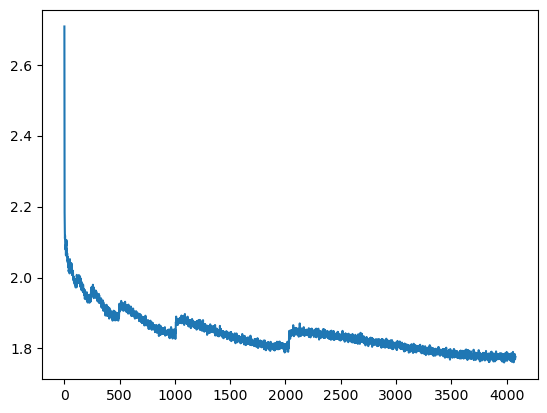

In [71]:
plt.plot(np.arange(len(Train)),Train)

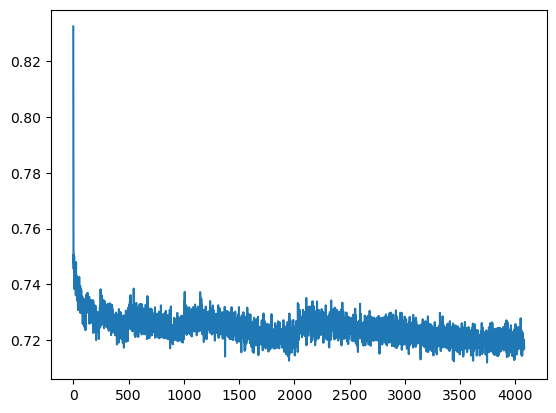

In [72]:
plt.plot(np.arange(len(Eval)),Eval)

In [29]:
fname = "models/stateATT_6L_12cont_biased sampling.pth" 
SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 


KeyboardInterrupt: 

In [ ]:
fname = "models/stateATT_6L_12cont_biased sampling.pth" 
SCORES = eval_model_PID(fname,train_dataloader,test_dataloader,val_dataloader)

In [ ]:
fname = "models/stateATT_6L_12cont_biased sampling.pth" 
SCORES = eval_model_acc_PID(fname,train_dataloader,test_dataloader,val_dataloader)